In [1]:
import pickle
import os
import tensorflow as tf
import matplotlib.pyplot as plt
# import mpl_toolkits.mplot3d as Axes3D

from database import *
from sklearn.manifold import TSNE

%matplotlib inline

# Datasets

Generate training, testing, and validation datasets

In [2]:
# Import data from database
step = 1/10e3  # microphone sample period, sec
mic_list = ("Ambient", "Mic 0", "Mic 1", "Mic 2", "Mic 3")  # for setting the legend
fs = 1/step  # sample rate, Hz

In [57]:
# Load data from the database
# host = "mysql.ecn.purdue.edu"  # 128.46.154.164
# user = "op_point_test"
# database = "op_point_test"
host = 'localhost'
user = 'root'
database = 'mysql'
table_name = '100_op_point_test'
password = 'admin'
# with open("password.txt", "r") as f:
#   password = f.read().rstrip()
eng = connect_to_db(host, user, password, database)
tic = timeit.default_timer()
data = import_data(eng, table_name)
toc = timeit.default_timer()
if eng.open:
    eng.close()
print("Elapsed time: {} sec".format(toc-tic))

Number of rows: 42331
Keys: ['temperature', 'staticP', 'dateTimeStamp', 'opPointAct', 'atmosphericP', 'flameStatus', 'opPointDes', 'dynamicP']
Loading data ................................................... done!
Elapsed time: 54.44733872698271 sec


In [3]:
# Import processed data from pickle
processed_data = []
for mic in mic_list:
    fname = os.path.join('..', 'Processed', 'short_fft_waterfall_{}.pickle'.format(mic))
#     fname = os.path.join('.', 'Processed', 'short_fft_waterfall_softmax_{}.pickle'.format(mic))
    processed_data.append(pickle.load(open(fname, 'rb')))

In [4]:
fname = os.path.join('..', 'Processed', 'K-means_results_4_centroids.pickle')
kmeans_data = pickle.load(open(fname, 'rb'))
assignments = kmeans_data['assignments']
print(assignments)

[1 1 1 ..., 1 1 1]


In [20]:
print(np.power(10, np.mean([row['res'][0,:] for row in processed_data], axis=1)/20))

[ 0.02470229  0.02452491  0.02547168  0.02053213  0.02165319]


In [27]:
# Get dataset for 16-feature k-means clustering
fname = os.path.join('..', 'Processed', 'tSNE_dataset_17_feat.pickle')
dataset = pickle.load(open(fname, 'rb'))
dataset = dataset['data'][:, 1:]  # remove existing labels taken from 11-feature k-means clustering
dataset.shape

(42332, 16)

In [28]:
dataset = dataset[:, :-5]
dataset.shape

(42332, 11)

In [29]:
labelset = np.zeros((len(assignments), np.max(assignments)+1), dtype=np.float32)
for i in range(len(assignments)):
    labelset[i, assignments[i]] = 1  # encode assignments as one-hot vectors
print(labelset.shape)
print('Assignments: {}'.format(assignments[1000:1010]))
print('One-hot encoded:\n{}'.format(labelset[1000:1010]))

(42332, 4)
Assignments: [1 1 1 1 3 1 1 1 1 1]
One-hot encoded:
[[ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]]


In [30]:
input_size = dataset.shape[1]
num_samples = dataset.shape[0]
batch_size = 64
num_unrollings = 10

In [31]:
output_size = labelset.shape[1]

In [32]:
class BatchGenerator(object):
    def __init__(self, data, batch_size, num_unrollings):
        self._data = data
        self._num_samples = data.shape[0]
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._num_samples // batch_size
        self._offset = 0
        self._last_batch = self._next_batch()

    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = self._data[self._offset:self._offset+self._batch_size, :]
        self._offset += self._batch_size
        if self._num_samples - self._offset < self._batch_size:
            self._offset = 0
        return batch

    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches

In [33]:
train_size = np.int(0.7*num_samples)
valid_size = len(dataset) - train_size
train_batches = BatchGenerator(dataset[:train_size,:], batch_size, num_unrollings)
valid_batches = BatchGenerator(dataset[train_size:,:], 1, 1)

In [34]:
train_label_batches = BatchGenerator(labelset[:train_size,:], batch_size, num_unrollings)
valid_label_batches = BatchGenerator(labelset[train_size:,:], 1, 1)

In [35]:
def logprob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10
    return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

# LSTM RNN Definition

Define the long short-term memory (LSTM) recurrent neural network (RNN). Borrowing heavily from the Deep Learning Udacity course.

In [36]:
num_nodes = 64  #TODO tune this!
num_steps = 1001

graph = tf.Graph()
with graph.as_default():
    # Parameters
    # Combined input, forget, memory cell, and output weights for input and previous state. Also biases.
    ifcox = tf.Variable(tf.truncated_normal([input_size, 4*num_nodes], 0.0, 1/np.sqrt(input_size)))
    ifcom = tf.Variable(tf.truncated_normal([num_nodes, 4*num_nodes], 0.0, 1/np.sqrt(input_size)))
    ifcob = tf.Variable(tf.zeros([1, 4*num_nodes]))
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = tf.Variable(tf.truncated_normal([num_nodes, output_size], 0.0, 1/np.sqrt(output_size)))
    b = tf.Variable(tf.zeros([output_size]))
    
    # Create saver
    saver = tf.train.Saver()
    
    # Definition of the cell computation
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        combined = tf.matmul(i, ifcox) + tf.matmul(o, ifcom) + ifcob
        input_gate = tf.sigmoid(combined[:, :num_nodes])
        forget_gate = tf.sigmoid(combined[:, num_nodes:2*num_nodes])
        update = combined[:, 2*num_nodes:3*num_nodes]
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(combined[:, 3*num_nodes:])
        return output_gate * tf.tanh(state), state
    
    # Input data
    train_data = list()
    train_labels = list()
    for _ in range(num_unrollings + 1):
        train_data.append(tf.placeholder(tf.float32, shape=[batch_size, input_size]))
        train_labels.append(tf.placeholder(tf.float32, shape=[batch_size, output_size]))
    train_inputs = train_data[:num_unrollings]
    train_outputs = train_labels[1:]  # labels are shifted by one time step.
    
    # Unrolled LSTM loop
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        output, state = lstm_cell(i, output, state)
        outputs.append(output)
    
    # Saving state across unrollings
    with tf.control_dependencies([saved_output.assign(output),
                                  saved_state.assign(state)]):
        # Classifier
        logits = tf.nn.xw_plus_b(tf.concat(0, outputs), w, b)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,
                tf.concat(0, train_outputs)))
#         loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,
#                               tf.concat(0, train_outputs)))
    
    # Optimizer
    global_step = tf.Variable(0)
#     learning_rate = tf.train.exponential_decay(10.0, global_step, 2*num_steps//3, 0.1, staircase=True)
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    optimizer = tf.train.AdamOptimizer()
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    
    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, input_size])
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(saved_sample_output.assign(tf.zeros([1, num_nodes])),
            saved_sample_state.assign(tf.zeros([1, num_nodes])))
    sample_output, sample_state = lstm_cell(sample_input, saved_sample_output,
            saved_sample_state)
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

# Run

Train the network on the dataset and observe the performance

In [37]:
summary_frequency = 100
mean_loss = 0

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized.')
    for step in range(num_steps):
        # Generate next training batch
        batches = train_batches.next()
        labels = train_label_batches.next()
        
        # Generate feed_dict
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
            feed_dict[train_labels[i]] = labels[i]
        _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
#                 [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        
        # Update to the user periodically
        if step % summary_frequency == 0:
            # Output some information about our training performance
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step {}: {}'.format(step, mean_loss))
#             print('Average loss at step {}: {} learning rate: {}'.format(step, mean_loss, lr))            
            mean_loss = 0
            print('Minibatch perplexity: {}'.format(float(np.exp(logprob(predictions,
                    np.concatenate(labels[1:], axis=0))))))

    # Measure validation set perplexity.
    reset_sample_state.run()
    valid_logprob = 0
    valid_percent = 0
    for num in range(valid_size):
        b = valid_batches.next()
        l = valid_label_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, l[1])
        if np.argmax(l) == np.argmax(predictions):
            valid_percent += 1
    print('Validation set perplexity: {}'.format(float(np.exp(valid_logprob / valid_size))))
    print('Validation set prediction accuracy: {}%'.format(100*valid_percent / valid_size))
    
    save_path = saver.save(session, './models/lstm.ckpt')
    print('Model saved in file: {}'.format(save_path))

Initialized.
Average loss at step 0: 1.9802360534667969
Minibatch perplexity: 7.244451479785369
Average loss at step 100: 0.908222596719861
Minibatch perplexity: 8.074085952531323
Average loss at step 200: 0.7235710065811872
Minibatch perplexity: 1.4277551994391227
Average loss at step 300: 0.6520721229910851
Minibatch perplexity: 2.6659510878330988
Average loss at step 400: 0.5258527206070721
Minibatch perplexity: 2.3212314786564456
Average loss at step 500: 0.49040923250839114
Minibatch perplexity: 2.3464853781255144
Average loss at step 600: 0.44495711240917446
Minibatch perplexity: 1.3677029687822646
Average loss at step 700: 0.39484124260023234
Minibatch perplexity: 1.0363157340256466
Average loss at step 800: 0.42329671419225634
Minibatch perplexity: 2.1394216302686
Average loss at step 900: 0.3871274442807771
Minibatch perplexity: 1.2316953420122596
Average loss at step 1000: 0.3548084774054587
Minibatch perplexity: 1.5075047478539731
Validation set perplexity: 1.408421121484047

# Analyze

Analyze the performance and see what we can do with it

In [238]:
#TODO
with tf.Session(graph=graph) as session:
    saver.restore(session, './tmp/model.ckpt')
    print('Model restored.')
    reset_sample_state.run()
    valid_logprob = 0
    for num in range(10):
        b = valid_batches.next()
        l = valid_label_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = logprob(predictions, l[1])
        print('Logprob prediction accuracy: {}'.format(np.exp(valid_logprob)))

Model restored.
Logprob prediction accuracy: 3.27499509365031
Logprob prediction accuracy: 4.305346330370888
Logprob prediction accuracy: 5.848128092794755
Logprob prediction accuracy: 8.95032183870408
Logprob prediction accuracy: 21.192523869801214
Logprob prediction accuracy: 34.57237037931048
Logprob prediction accuracy: 33.55192325402382
Logprob prediction accuracy: 22.4291848650905
Logprob prediction accuracy: 11.539374057178454
Logprob prediction accuracy: 5.9423446453489825


# K-means clustering of dataset

Attempt to divide the data into `n` seperable clusters.

In [13]:
blow_outs = [ind for ind in range(num_samples) if dataset[ind, 0] == 0]
print(blow_outs)

[403, 1004, 1310, 1711, 2919, 4018, 4523, 5524, 6225, 7226, 7527, 8766, 9967, 10506, 12018, 13219, 13922, 14447, 14453, 15045, 15046, 16039, 17120, 19823, 20324, 20330, 20742, 21487, 22683, 23789, 24305, 24807, 25495, 26014, 27343, 28557, 28864, 29743, 30096, 30798, 32015, 32221, 33522, 33723, 35035, 35446, 36522, 37428, 37742, 38451, 38903, 39704, 39705, 40212, 40213, 40219, 41358]


In [14]:
dist_history = []
n_clusters = 4

In [26]:
n_clusters = 4
def choose_random_centroids(samples, n_clusters):
    """Step 0: Initialisation: Select `num_clusters` number of random points."""
    random_indices = tf.random_shuffle(tf.range(0, num_samples))
    begin = [0,]
    size = [n_clusters,]
    size[0] = n_clusters
    centroid_indices = tf.slice(random_indices, begin, size)
    initial_centroids = tf.gather(samples, centroid_indices)
    return initial_centroids

tf.reset_default_graph()
kmeans = tf.Graph()
with kmeans.as_default():
    # def configure_kmeans(n_clusters):
    points = tf.constant(dataset[:num_samples])
    cluster_assignments = tf.Variable(tf.zeros([num_samples], dtype=tf.int64))

    # Initialize centroids to locations of `n_clusters` random samples
    centroids = tf.Variable(choose_random_centroids(points, n_clusters))

    # Replicate to N copies of each centroid and K copies of each
    # point, then subtract and compute the sum of squared distances.
    rep_centroids = tf.reshape(tf.tile(centroids, [num_samples, 1]), [num_samples, n_clusters, input_size])
    rep_points = tf.reshape(tf.tile(points, [1, n_clusters]), [num_samples, n_clusters, input_size])

    #TODO modify the cost function for k-means clustering.
    sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids),
                                reduction_indices=2)

    # Use argmin to select the lowest-distance point
    best_centroids = tf.argmin(sum_squares, 1)
    did_assignments_change = tf.reduce_any(tf.not_equal(best_centroids, 
                                                        cluster_assignments))

    def bucket_mean(data, bucket_ids, num_buckets):
        total = tf.unsorted_segment_sum(data, bucket_ids, num_buckets)
        count = tf.unsorted_segment_sum(tf.ones_like(data), bucket_ids, num_buckets)
        return total / count

    means = bucket_mean(points, best_centroids, n_clusters)

    # Do not write to the assigned clusters variable until after
    # computing whether the assignments have changed - hence with_dependencies
    with tf.control_dependencies([did_assignments_change]):
        do_updates = tf.group(
            centroids.assign(means),
            cluster_assignments.assign(best_centroids))

In [27]:
max_iters = 1000  # stop criterion for k-means algorithm
repeats = 1000//n_clusters  # number of times to train the same k-means, hoping to find a best result
progress = max_iters//50
MC_progress = repeats//10 + 1
percent = 0
centers_hist = []
assignments_hist = []
mean_hist = []
# num_clusters = 4  # blowout, attached, detached, going unstable

with tf.Session(graph=kmeans) as sess:
    for repeat in range(repeats):
        if repeat % MC_progress == 0:
            print('{}% complete ...'.format(percent), flush=True)
            percent += 10
        print('Working ', end='', flush=True)
        tic = timeit.default_timer()
        sess.run(tf.initialize_all_variables())
        changed = True
        iters = 0

        # Run k-means loop
        while changed and iters < max_iters:
            if iters % progress == 0:
                print('.', end='', flush=True)
            iters += 1
            [changed, _] = sess.run([did_assignments_change, do_updates])
        toc = timeit.default_timer()
        print(" {} clusters in {} seconds {} iterations".format(n_clusters, toc-tic, iters))

        # Save the results
        [centers, assignments] = sess.run([centroids, cluster_assignments])
        mean_dist = np.mean([dist[ind] for dist, ind in zip(sum_squares.eval(), assignments)], axis=0)
        centers_hist.append(centers)
        assignments_hist.append(assignments)
        mean_hist.append(mean_dist)
        if any([center[0] < 1e-5 for center in centers]):  # break if we find the blow-outs
            break
    
    min_ind = np.argmin(mean_hist)
    mean_dist = np.min(mean_hist)
    centers = centers_hist[min_ind]
    assignments = assignments_hist[min_ind]
    dist_history.append(mean_dist)
    print("Centroids:")
    print(centers)
    print("Cluster assignments: ", assignments)
    print("Mean total distance to nearest: {}".format(mean_dist))

0% complete ...
Working ..... 6 clusters in 3.505222392000178 seconds 87 iterations
Working ...... 6 clusters in 4.1733507140002075 seconds 113 iterations
Working .......... 6 clusters in 7.372415365000052 seconds 200 iterations
Working ... 6 clusters in 2.094004158000189 seconds 57 iterations
Working ..... 6 clusters in 3.609043653000299 seconds 98 iterations
Working ....... 6 clusters in 4.512612783999884 seconds 122 iterations
Working .... 6 clusters in 2.63704847300005 seconds 72 iterations
Working ... 6 clusters in 1.8130054230000496 seconds 49 iterations
Working ...... 6 clusters in 3.8319565340002555 seconds 103 iterations
Working ...... 6 clusters in 3.7734121119997326 seconds 103 iterations
Working .... 6 clusters in 2.631597520000014 seconds 71 iterations
Working ...... 6 clusters in 4.291422551000323 seconds 116 iterations
Working ..... 6 clusters in 3.3669631530001425 seconds 91 iterations
Working ... 6 clusters in 1.988100504999693 seconds 53 iterations
Working ... 6 clust

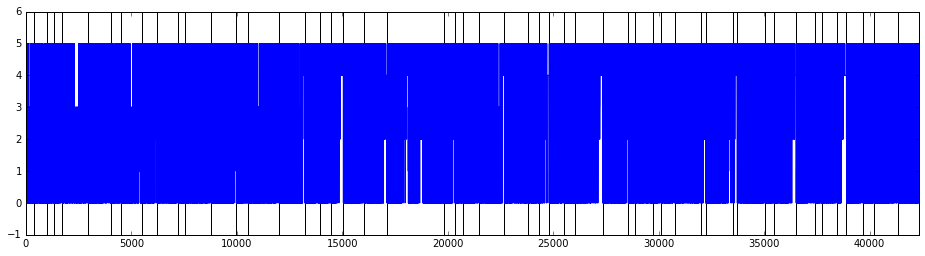

In [29]:
plt.figure(figsize=(16, 4))
plt.plot(assignments)
plt.vlines(blow_outs, -1, n_clusters)
plt.ylim((-1, n_clusters))
plt.xlim((0, num_samples))
plt.show()

[47.801541779019225, 34.154192497570918, 28.472318547015465, 25.608139514374191, 23.285376013325973]


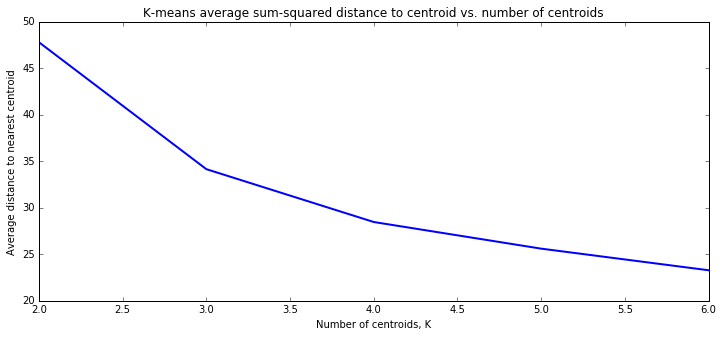

In [28]:
print(dist_history)
plt.figure(figsize=(12,5))
plt.plot(range(2, len(dist_history)+2), dist_history, linewidth=2)
plt.title('K-means average sum-squared distance to centroid vs. number of centroids')
plt.xlabel('Number of centroids, K')
plt.ylabel('Average distance to nearest centroid')
plt.show()

In [186]:
centers = np.array(centers)
assignments = np.array(assignments)
dist_history = np.array(dist_history)

In [7]:
fname = os.path.join('..', 'Processed', 'K-means_results_{}_centroids.pickle'.format(n_clusters))

In [1]:
to_pickle = {'centers': centers,
             'assignments': assignments,
             'distance_vs_num_centers': dist_history}
pickle.dump(to_pickle, open(fname, 'wb'))

NameError: name 'os' is not defined

In [8]:
kmeans_data = pickle.load(open(fname, 'rb'))
print(kmeans_data)

{'assignments': array([1, 1, 1, ..., 1, 1, 1]), 'centers': array([[ 1.        ,  2.81591334,  0.03357434,  0.07389693,  0.06184875,
         0.0206192 ,  0.02009801],
       [ 1.        ,  2.52701412,  0.02998303,  0.02804071,  0.02945956,
         0.02154577,  0.02185534],
       [ 1.        ,  2.63422938,  0.02761916,  0.03205354,  0.03003301,
         0.02001018,  0.01999879],
       [ 0.        ,  2.65465485,  0.01905372,  0.03090722,  0.02950687,
         0.01450436,  0.01280015]]), 'distance_vs_num_centers': array([ 0.0036334 ,  0.00230521,  0.00114152,  0.00082087,  0.00063533,
        0.0005279 ])}


In [10]:
kmeans_data['assignments'].shape

(42332,)

# Visualize Clustering

Visualize the data ponit clustering with [t-SNE][1]

[1]: http://lvdmaaten.github.io/tsne/

In [6]:
fname = os.path.join('..', 'Processed', 'tSNE_processed_16000.pickle')
dataset = pickle.load(open(fname, 'rb'))
keys = dataset.keys()
for key in keys:
    print('{}\t{}'.format(key, dataset[key].shape))

emb0	(1406, 2)
emb1	(11696, 2)
emb3	(21, 2)
emb2	(2877, 2)


In [7]:
print(dataset['emb3'][:10, :])

[[ 2.36226561 -3.14398297]
 [ 2.38274978 -3.17627764]
 [ 2.35436275 -3.10345309]
 [ 2.39066863 -3.19168002]
 [ 6.64528216 -1.69966622]
 [ 2.49564375 -3.44225289]
 [ 2.45966621 -3.39414062]
 [ 7.78094931  1.28235633]
 [ 5.91211549  0.07334727]
 [ 2.0379307   0.07048099]]


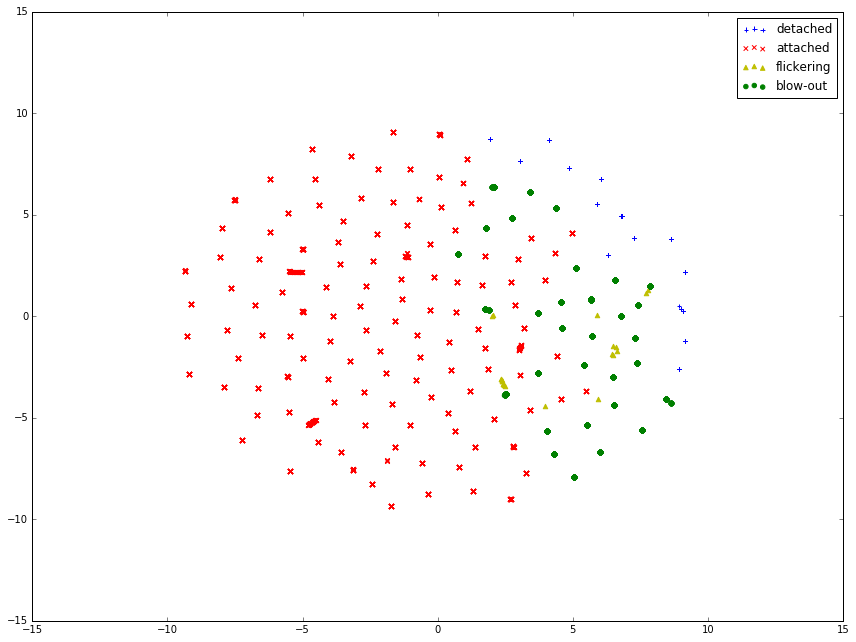

In [8]:
colors = ('b', 'r', 'y', 'g')
markers = ('+', 'x', '^', 'o')
labels = ('detached', 'attached', 'flickering', 'blow-out')
plt.figure(figsize=(12, 9))
for key, color, marker in zip(keys, colors, markers):
    if dataset[key].shape[0] > 0:
        plt.scatter(dataset[key][:, 0], dataset[key][:, 1], marker=marker, color=color)
plt.legend(labels)
plt.tight_layout()
plt.show()